In [4]:
import librosa
import numpy as np
from scipy.fftpack import dct
from scipy import signal, io
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#preemphasis config 
alpha = 0.97

# Enframe config
frame_len = 400      # 25ms, fs=16kHz
frame_shift = 160    # 10ms, fs=15kHz
fft_len = 512

# Mel filter config
num_filter = 23
num_mfcc = 12

In [68]:
class Solution(object):
    
    def __init__():
        
        # preemphasis config
        self.alpha = 0.97
        
        # Enframe config
        self.frame_len = 400    # 25ms, fs=16kHz
        self.frame_shift = 160  # 10ms, fs=15kHz
        self.fft_len = 512
        
        # Mel filter config
        self.num_filter = 23
        self.num_mfcc = 12

def plot_spectrogram(spec, note, file_name):
    """
    Draw the spectrogram picture
    :param spec: a feature_dim by num_frames array(real)
    :param note: title of the picture
    :file_name: name of the file
    """
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(note)
    plt.tight_layout()
    plt.savefig(file_name)

# Emframe with Hanming window function
def preemphasis(x, coeff):
    """
    Perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is no filter, default is 0.97
    :returns: the filtered signal.
    """
    return np.append(x[0], x[1:] - coeff * x[:-1])

def enframe(signal, frame_len, frame_shift):
    """
    Enframe with Hamming window function.
    :param signal: The signal be enframed.
    :param win: window function, default Hamming.
    :returns: the enframed signal, num_frames by frame_len array
    """
    win = np.hamming(frame_len)
    num_samples = signal.size
    num_frames = np.floor((num_samples - frame_len) / frame_shift) + 1
    frames = np.zeros((int(num_frames), frame_len))
    for i in range(int(num_frames)):
        frames[i, :] = signal[i * frame_shift:i * frame_shift + frame_len]
        frames[i, :] = frames[i, :] * win
        
    return frames

def _stft_parameters():
    
    n_fft = 1024
    hop_length = int(frame_shift / 1000 * 16000)
    win_length = int(frame_len / 1000 * 16000)
    return n_fft, hop_length, win_length
    

def get_spectrum(frames, fft_len):
    """
    Get spectrum using fft
    :param frames: the enframed signal, num_frames by frame_len array
    :param fft_len: FFT length, default 512
    :returns: spectrum, a num_frames by fft_len/2 + 1 array(real)
    """
    cFFT = np.fft.fft(frames, n=fft_len)
    valid_len = int(fft_len / 2) + 1
    spectrum = np.abs(cFFT[:, 0:valid_len])
    return spectrum

def fbank_ops(spectrum, num_filter):
    """
    Get mel filter bank feature from spectrum
    Fbank特征提取流程：
    语音信号->预加重->分帧加窗->DFT->梅尔滤波器组->Log Operation ==> Fbank
    :param spectrum: a num_frames by fft_len/2 + 1 array(real)
    :param num_filter: mel filters number, default 23
    :returns: fbank feature, a num_frames by num_filter array
    DON'T FORGET LOG OPERATION AFTER MEL FILTER
    """
    low_freq_mel = 0
    high_freq_mel = 2596 * np.log10(1 + (fs / 2) / 700)

    mel_filter_num = num_filter
    mel_points = np.linspace(low_freq_mel, high_freq_mel, mel_filter_num + 2)
    hz_points = 700 * (10 ** (mel_points / 2595) - 1)

    _fbank = np.zeros((mel_filter_num, int(fft_len / 2 + 1))) # 各个mel滤波器在能量谱对应点的取值
    _bin = (hz_points / (fs / 2)) * (fft_len / 2) # 各个mel滤波器中心点对应FFT的区域编码，找到有值的位置
    for i in range(1, mel_filter_num + 1):
        left = int(_bin[i - 1])
        center = int(_bin[i])
        right = int(_bin[i + 1])
        for j in range(left, center):
            _fbank[i - 1, j + 1] = (j + 1 - _bin[i - 1]) / (_bin[i] - _bin[i - 1])
        for j in range(center, right):
            _fbank[i-1, j+1] = (_bin[i+1] - (j + 1)) / (_bin[i+1] - _bin[i])
    
    filter_banks = np.dot(spectrum, _fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)
    
    return filter_banks

def mfcc_ops(filater_banks, num_mfcc):
    """
    Get mfcc feature from fbank feature
    MFCC特征提取流程：
    FBank->IDFT ==> Fbank
    :param fbank: a num_frames by num_filter array(real)
    :param num_mfcc: mfcc number, default 12
    :returns: mfcc feature, a num_frames by num_mfcc array
    """
    _mfcc = dct(filater_banks, type=2, axis=1, norm='ortho')[:, 1:(num_mfcc + 1)]
    # One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed 
    # to improve speech recognition in noisy signals.
    (nframes, ncoeff) = _mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (num_mfcc / 2) * np.sin(np.pi * n / num_mfcc)
    _mfcc *= lift
    return _mfcc
    
def write_file(feats, filename):
    """
    Write the feature to file
    :param feats: a num_frames by feature_dim array(real)
    :param file_name: name of the file
    """
    f = open(filename, 'w')
    (row, col) = feats.shape
    for i in range(row):
        f.write('[')
        for j in range(col):
            f.write(str(feats[i, j]) + ' ')
        f.write(']\n')
    f.close()

In [69]:
wav, fs = librosa.load('./test.wav', sr=None)

In [70]:
_signal = preemphasis(wav, coeff=alpha)
frames = enframe(_signal, 
                 frame_len=frame_len, 
                 frame_shift=frame_shift)
spectrum = get_spectrum(frames, fft_len=fft_len)
fbank = fbank_ops(spectrum, num_filter=23)
mfcc = mfcc_ops(fbank, 12)

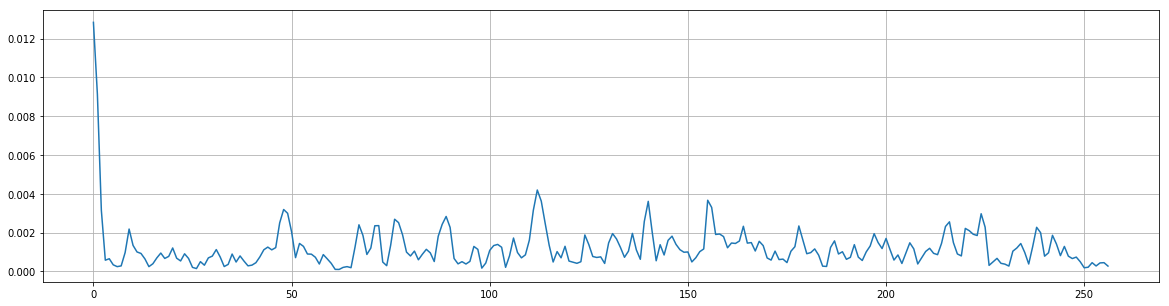

In [27]:
plt.figure(figsize=(20, 5))
# 能量谱
plt.plot(spectrum[1])
plt.grid()

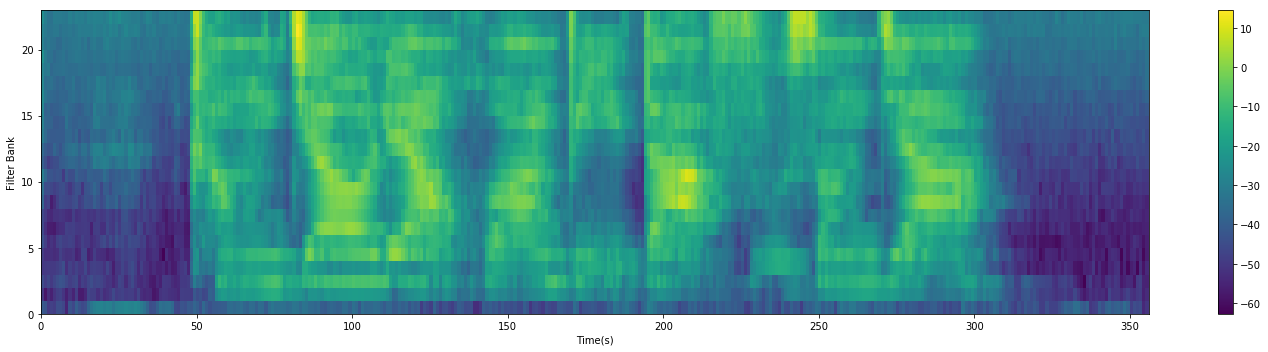

In [71]:
plot_spectrogram(fbank.T, "Filter Bank", "Fbank.png")

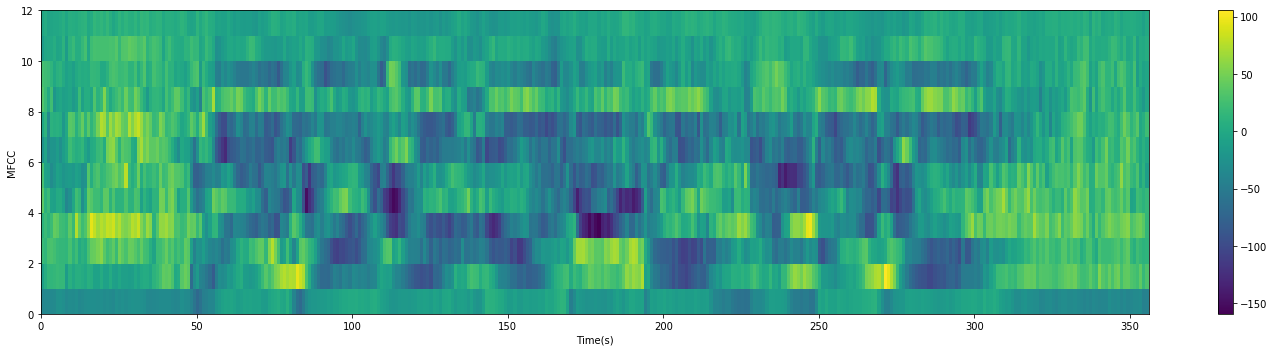

In [73]:
plot_spectrogram(mfcc.T, "MFCC", "MFCC.png")